In [6]:
!pip install torch torchvision torchaudio
!pip install -Iv numpy==1.26.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Obtaining dependency information for numpy==1.26.4 from https://files.pythonhosted.org/packages/4b/d7/ecf66c1cd12dc28b4040b15ab4d17b773b87fa9d29ca16125de01adb36cd/numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  changing mode of /usr/local/bin/f2py to 755


In [10]:
!pip install -Iv grad-cam==1.4.5

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 6.9 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-so6lsiqw
  Entered build tracker: /tmp/pip-build-tracker-so6lsiqw
  Created temporary directory: /tmp/pip-install-zceq4u8f
  Created temporary directory: /tmp/pip-ephem-wheel-cache-e88hjzfv
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  Starting new HTTPS connection (1)

In [5]:
!pip install -Iv matplotlib==3.9.2

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Obtaining dependency information for matplotlib==3.9.2 from https://files.pythonhosted.org/packages/8d/9d/d06860390f9d154fa884f1740a5456378fb153ff57443c91a4a32bab7092/matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/99/e6/d11966962b1aa515f5586d3907ad019f4b812c04e4546cc19ebf62b5178e/contourpy-1.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached contourpy-1.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.met

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing Layer 1/12


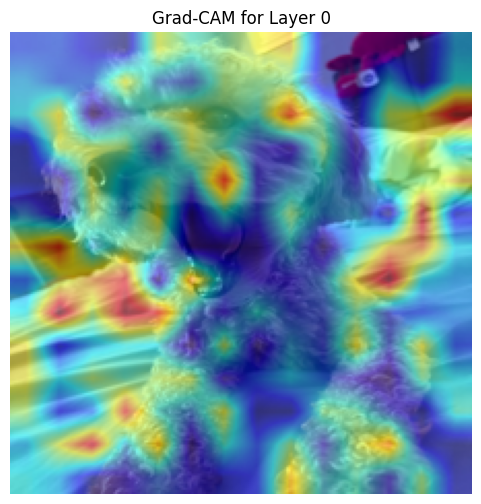

Processing Layer 2/12


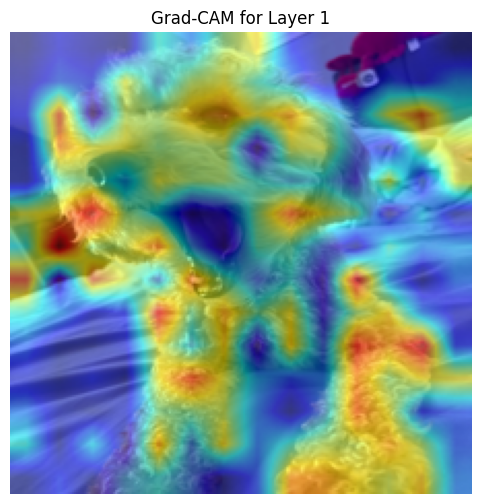

Processing Layer 3/12


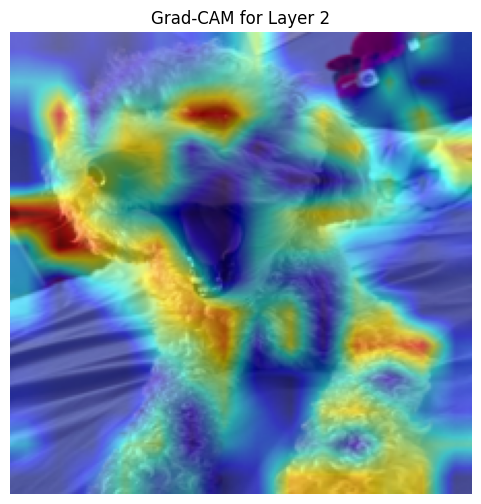

Processing Layer 4/12


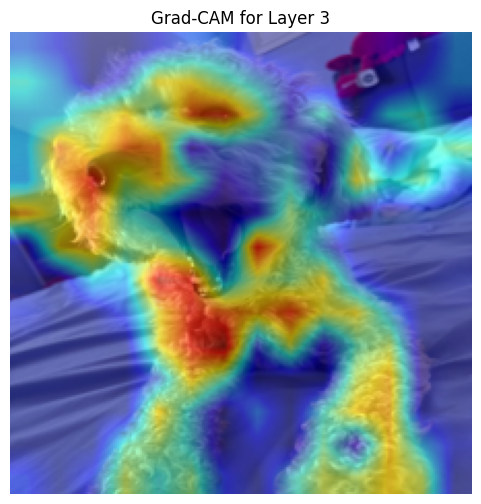

Processing Layer 5/12


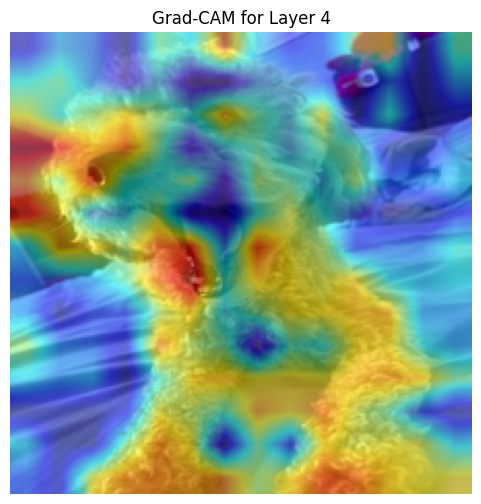

Processing Layer 6/12


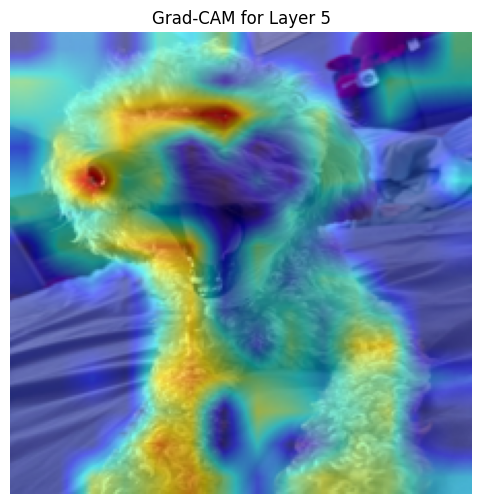

Processing Layer 7/12


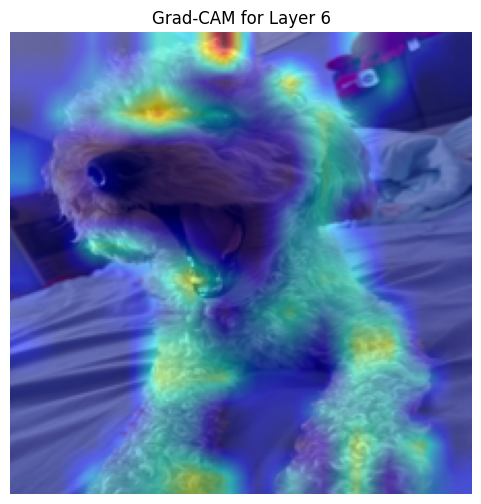

Processing Layer 8/12


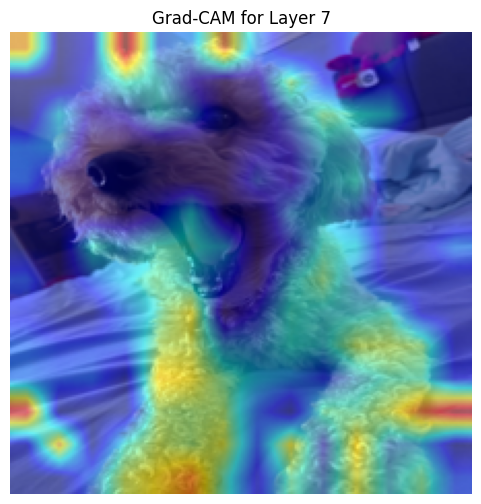

Processing Layer 9/12


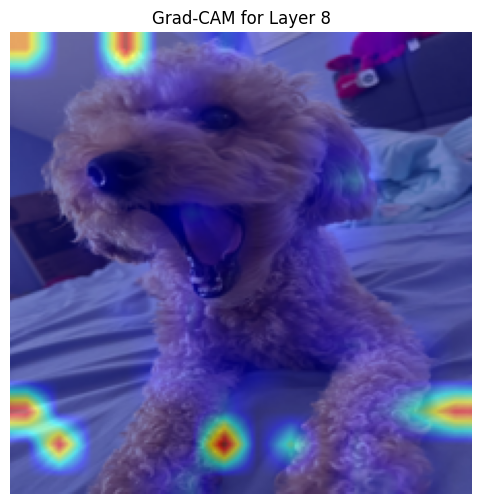

Processing Layer 10/12


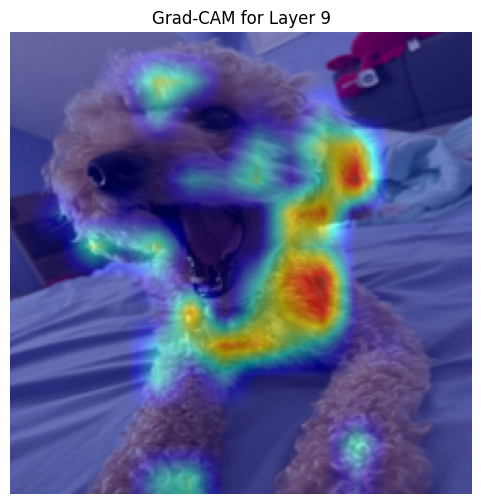

Processing Layer 11/12


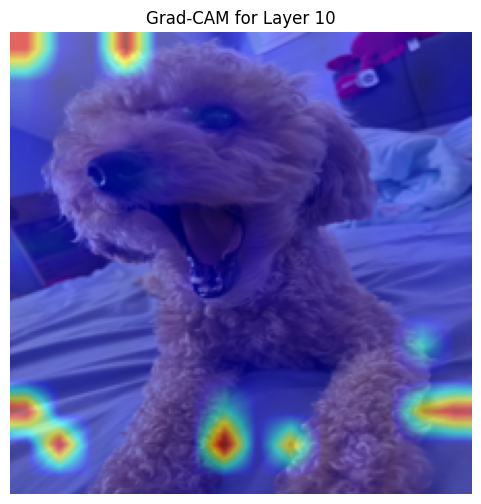

Processing Layer 12/12


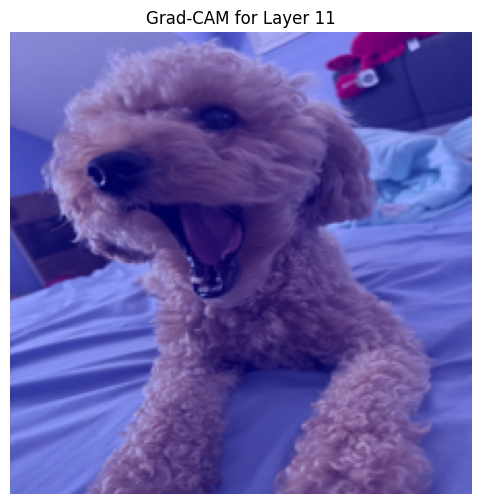

In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTImageProcessor
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Loading and preprocess the image
img = Image.open("/content/wangzai.jpeg").convert('RGB')
img_resized = img.resize((224, 224))
img_np = np.array(img_resized).astype(np.float32) / 255.0

image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
inputs = image_processor(images=img, return_tensors="pt")
input_tensor = inputs['pixel_values']

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
model.eval()

# Wrap the model
class ViTWrapper(nn.Module):
    def __init__(self, model):
        super(ViTWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        outputs = self.model(pixel_values=x)
        return outputs.logits

wrapped_model = ViTWrapper(model)

# Move model and input to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
wrapped_model.to(device)
input_tensor = input_tensor.to(device)

# Define the reshape_transform
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))
    result = result.permute(0, 3, 1, 2)
    return result

# Number of transformer blocks
num_layers = len(model.vit.encoder.layer)

# Loop over each layer
for idx in range(num_layers):
    print(f"Processing Layer {idx+1}/{num_layers}")

    # Define the target layer
    target_layer = wrapped_model.model.vit.encoder.layer[idx].output

    # Initialize Grad-CAM
    cam = GradCAM(model=wrapped_model,
                  target_layers=[target_layer],
                  reshape_transform=reshape_transform)

    # Forward pass
    outputs = wrapped_model(input_tensor)
    predicted_class = outputs.argmax(dim=-1).item()

    # Define the target category
    targets = [ClassifierOutputTarget(predicted_class)]

    # Compute the CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0]

    # Overlay the CAM on the image
    visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

    # Plot results
    plt.figure(figsize=(6, 6))
    plt.imshow(visualization)
    plt.title(f'Grad-CAM for Layer {idx}')
    plt.axis('off')
    plt.show()
